# Univariate Time Series Alignment Tutorial
Created by Ron Shapira Weber - email: ronsha@post.bgu.ac.il

In this notebook we are going to learn how use the Regularization-free Diffeomorphic Temporal Alignment Net [1] (RF-DTAN) to align single-channel time series from the UCR time series classification archive [3].  

We will use [TSAI](https://timeseriesai.github.io/tsai/) implementation of InceptionTime for the localization net backbone [2].



**References**:

[1] - Regularization-free Diffeomorphic Temporal Alignment Nets (ICML 2023)

[2] - Inceptiontime: Finding alexnet for time series classification (Data Mining and Knowledge Discovery 2020)

[3] - The UCR time series archive (IEEE/CAA Journal of Automatica 2019)


# Setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch
import numpy as np

from models.RFDTAN import RFDTAN
from models.trainer import Trainer
import matplotlib.pyplot as plt

from helper.UCR_loader import get_UCR_data
from tsai.data.external import get_UCR_univariate_list


from config import get_argparser
from helper.NCC import NCC_pipeline
from helper.plotting_torch import plot_signals
from nb_utils import plot_ts

In [2]:
# Jupyter args
# load changes from imports every 2 seconds
%load_ext autoreload
%autoreload 2

# Matplotlib
%matplotlib inline

In [3]:
parser = get_argparser()
args = parser.parse_args("")

In [4]:
get_UCR_univariate_list()

['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'ElectricDevices',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

# Config
Here we will choose the dataset, backbone and loss function.

* ICAE - Inverse Consistecny Averaging Error
* WCSS - Within-Class Sum of Squares
* Smoothness Prior - regularization on the predcited CPA field. Required for the WCSS losses. 
* n_recurrences - iterative alignment. Does not increase the number of trainable parameters. Does increase training during and memory (i.e., gradient update)
* tess_size - the finess of the partition. 


In [5]:
args.backbone = "InceptionTime"
args.dataset = "ECGFiveDays"
args.ICAE_loss = True
args.ICAE_triplets_loss =False
args.WCSS_loss = False
args.WCSS_triplets_loss = False
args.smoothness_prior = False
args.zero_boundary = True
args.n_recurrences = 4
args.batch_size = 128
args.n_epochs = 500
args.tess_size = 16
args.lr = 0.0005
args.no_validation = True

In [6]:
val_split = 0 if args.no_validation else 0.2
train_loader, val_loader, test_loader = get_UCR_data(
    dataset_name=args.dataset,
    batch_size=args.batch_size,
    val_split=val_split,
    data_dir=args.data_dir,
    swap_channel_dim=True,
)

classes = torch.unique(train_loader.dataset[:][1])
n_classes = len(classes)
channels, ts = train_loader.dataset[0][0].shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = RFDTAN(
    ts,
    channels,
    tess=args.tess_size,
    n_recurrence=args.n_recurrences,
    zero_boundary=args.zero_boundary,
    device=device,
    backbone=args.backbone,
)


ECGFiveDays dataset details:
    X train.shape: (23, 1, 136)
    X test.shape: (861, 1, 136)
    y train.shape: (23,)
    y test.shape: (861,)
    number of classes: 2
    number of (train) samples: 23
    number of channels: 1
    input shape: 136
Using /home/ron/.cache/torch_extensions/py39_cu102 as PyTorch extensions root...
Emitting ninja build file /home/ron/.cache/torch_extensions/py39_cu102/cpab_cpu/build.ninja...
Building extension module cpab_cpu...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module cpab_cpu...
succesfully compiled cpu source
Using /home/ron/.cache/torch_extensions/py39_cu102 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ron/.cache/torch_extensions/py39_cu102/cpab_gpu/build.ninja...
Building extension module cpab_gpu...
Allowing ninja to set a default number of workers... (overridable by setting the

In [7]:

pytorch_total_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print("# Trainable parameters:", pytorch_total_params)
print(model)

# Trainable parameters: 397583
RFDTAN(
  (dropout): Dropout(p=0.1, inplace=False)
  (backbone): InceptionTime(
    (inceptionblock): InceptionBlock(
      (inception): ModuleList(
        (0): InceptionModule(
          (convs): ModuleList(
            (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (maxconvpool): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (concat): Concat(dim=1)
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
        (1): InceptionModule(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,),

In [8]:

# Train
trainer_ucr = Trainer(
    exp_name="my_exp_name",
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    args=args)

trainer_ucr.train()
torch.cuda.empty_cache()


100%|██████████████████████████████████████████████| 500/500 [00:51<00:00,  9.78Epoch/s, train_loss=0.00578, val_loss=0.00578]


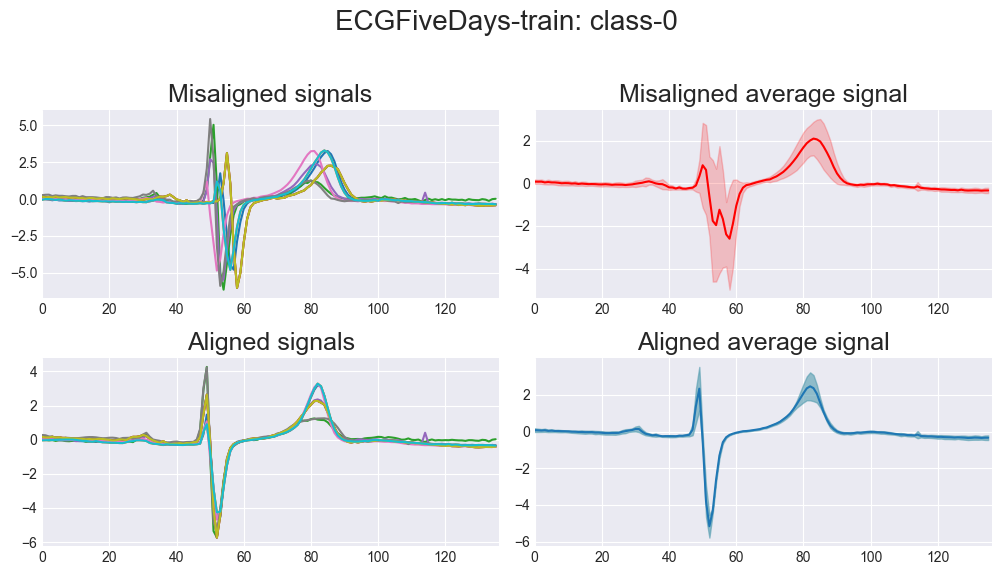

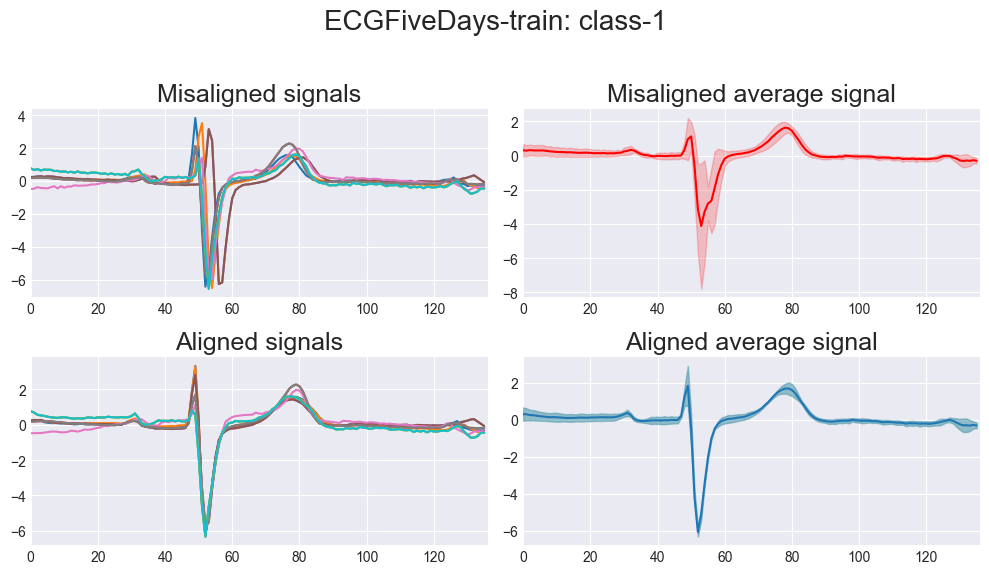

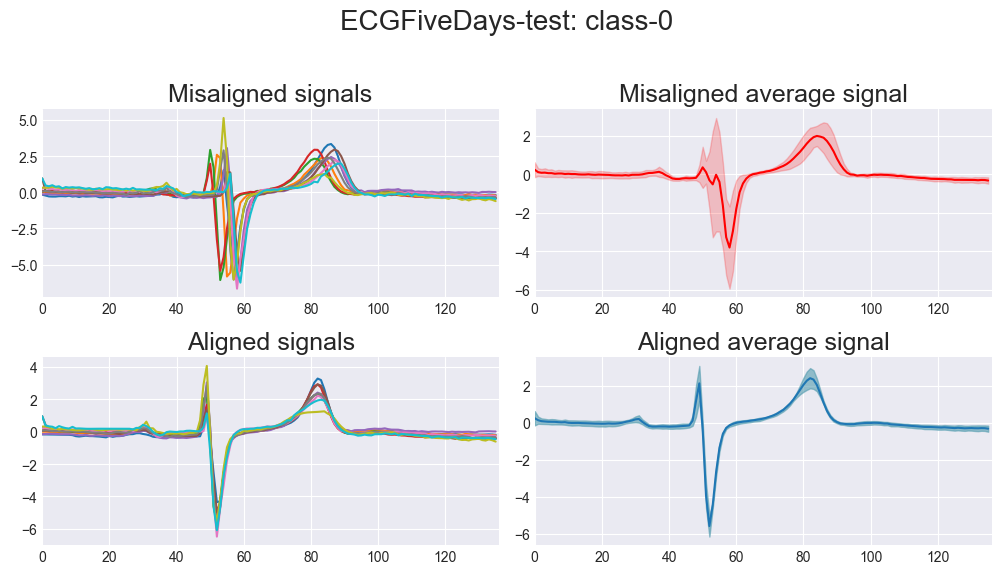

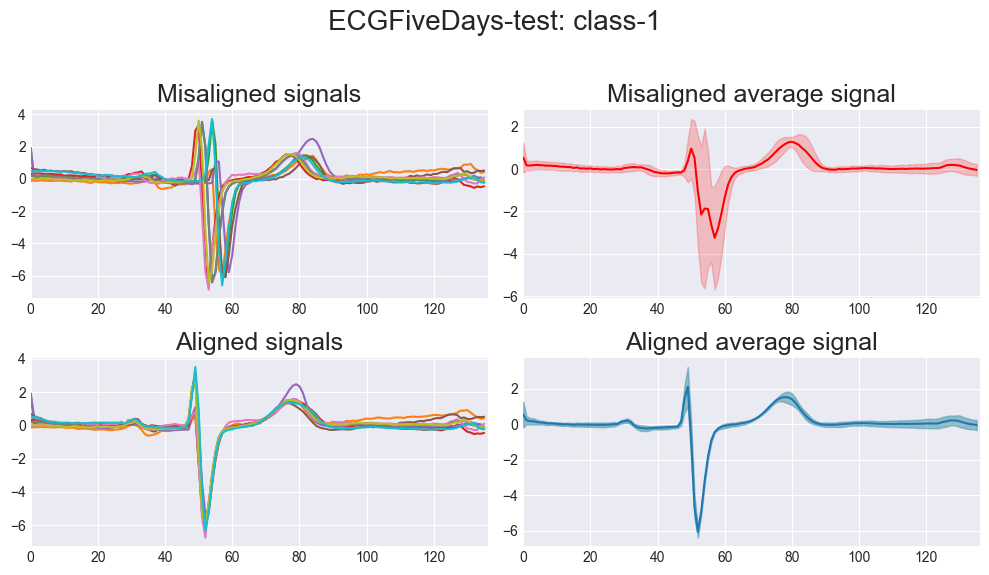

In [9]:
# Plot alignment
X_train, y_train = train_loader.dataset[:][0], train_loader.dataset[:][1]
X_test, y_test = test_loader.dataset[:][0], test_loader.dataset[:][1]
sets_dict = {
    "train": (X_train, y_train),
    "test": (X_test, y_test),
}
plot_signals(
    model, device=device, dataset_name=args.dataset, sets_dict=sets_dict

)



In [10]:
# Evaluate via NCC
res_dict = NCC_pipeline(model, train_loader, test_loader, args)


NCC Pipeline
Baseline: ECGFiveDays results: 0.6898954703832753
DTAN: ECGFiveDays results: 0.9883855981416957
